In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
import random, math, os, re

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

#for CNN model
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D

In [17]:
from keras.models import load_model
model = load_model('model_hiragana_recognition_cnn.h5')

In [18]:
thresh = 40
def im_clean(img):
    ## remove noices
    img = cv.medianBlur(img, 3)
    ret, img = cv.threshold(img, thresh, 255, cv.THRESH_TOZERO)
    img = cv.GaussianBlur(img, (3,3), 0)
    ret, img = cv.threshold(img, thresh, 255, cv.THRESH_TOZERO)
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, -1)
    # img = cv.GaussianBlur(img,(9,9),0)
    # ret, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel, iterations=1)
    # img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.erode(img, kernel, iterations=1)
    return img

def im_bin(img):
    ret, img = cv.threshold(img, thresh, 255, cv.THRESH_BINARY)
    return img


In [19]:
img_rows, img_cols = 84, 84

def im_reshape(img): # reshape the handwriting part into 64x64, in a 84x84 img. The surrounding border is consist of zeroes.
    ## construct 4x84 frme, reshape the handwrting part into 64x64
    fig = np.zeros((84, 84), dtype=np.uint8)
    c_axis = img.sum(axis=0)
    c_axis = np.nonzero(c_axis)[0]
    # print(c_axis)
    # c_min, c_max = c_axis[0], c_axis[-1]
    c_min, c_max = max(0, c_axis[0] - 5), min(img.shape[1], c_axis[-1] + 5)
    r_axis = img.sum(axis=1)
    r_axis = np.nonzero(r_axis)[0]
    # print(r_axis)
    # r_min, r_max = r_axis[0], r_axis[-1]
    r_min, r_max = max(0, r_axis[0] - 5), min(img.shape[0], r_axis[-1] + 5)
    img = img[r_min:r_max, c_min:c_max]
    img = cv.resize(img, (64, 64))
    fig[11:75, 11:75] = img
    return fig


In [20]:
my_handwritings = []
answers_myhw = []
for file in os.listdir("test_my_handwriting"):
    # print(file)
    key = re.search(r'_(\w+?)_', file).group(1)
    # print(key, end=", ")
    answers_myhw.append(key)
    img = cv.imread(f"test_my_handwriting/{file}", cv.IMREAD_GRAYSCALE)
    img = 255 - img
    # print(img.shape)
    img = im_reshape(im_bin(img))
    my_handwritings.append(img)

my_handwritings = np.array(my_handwritings)
print(my_handwritings.shape)
# print(answers_myhw)

(92, 84, 84)


In [21]:
## standardize X_train and X_test
def std_X(X):
    X = X.astype('float32') / 255
    return X


In [22]:
inv_romanji_dict = {0: 'ya', 1: 'to', 2: 'ne', 3: 'no', 4: 'shi', 5: 'ri', 6: 'se', 7: 'ku', 8: 'na', 9: 'he', 10: 'me', 11: 'mi', 12: 'ki', 13: 'ho', 14: 'hi', 15: 'n', 16: 'ta', 17: 'i', 18: 'wa', 19: 'ke', 20: 'ko', 21: 'ni', 22: 'pi', 23: 'ra', 24: 'ro', 25: 'sa', 26: 'fu', 27: 'te', 28: 'tsu', 29: 'o', 30: 'ma', 31: 'yu', 32: 'da', 33: 'su', 34: 'yo', 35: 'ru', 36: 'mu', 37: 'chi', 38: 'nu', 39: 'tu', 40: 'wo', 41: 'si', 42: 'ji', 43: 'ha', 44: 'ba', 45: 'ka', 46: 'a', 47: 'mo', 48: 're', 49: 'u', 50: 'e', 51: 'so'}

(92, 84, 84, 1)
Number of errors_myhw = 16/92
Accuracy: 0.83


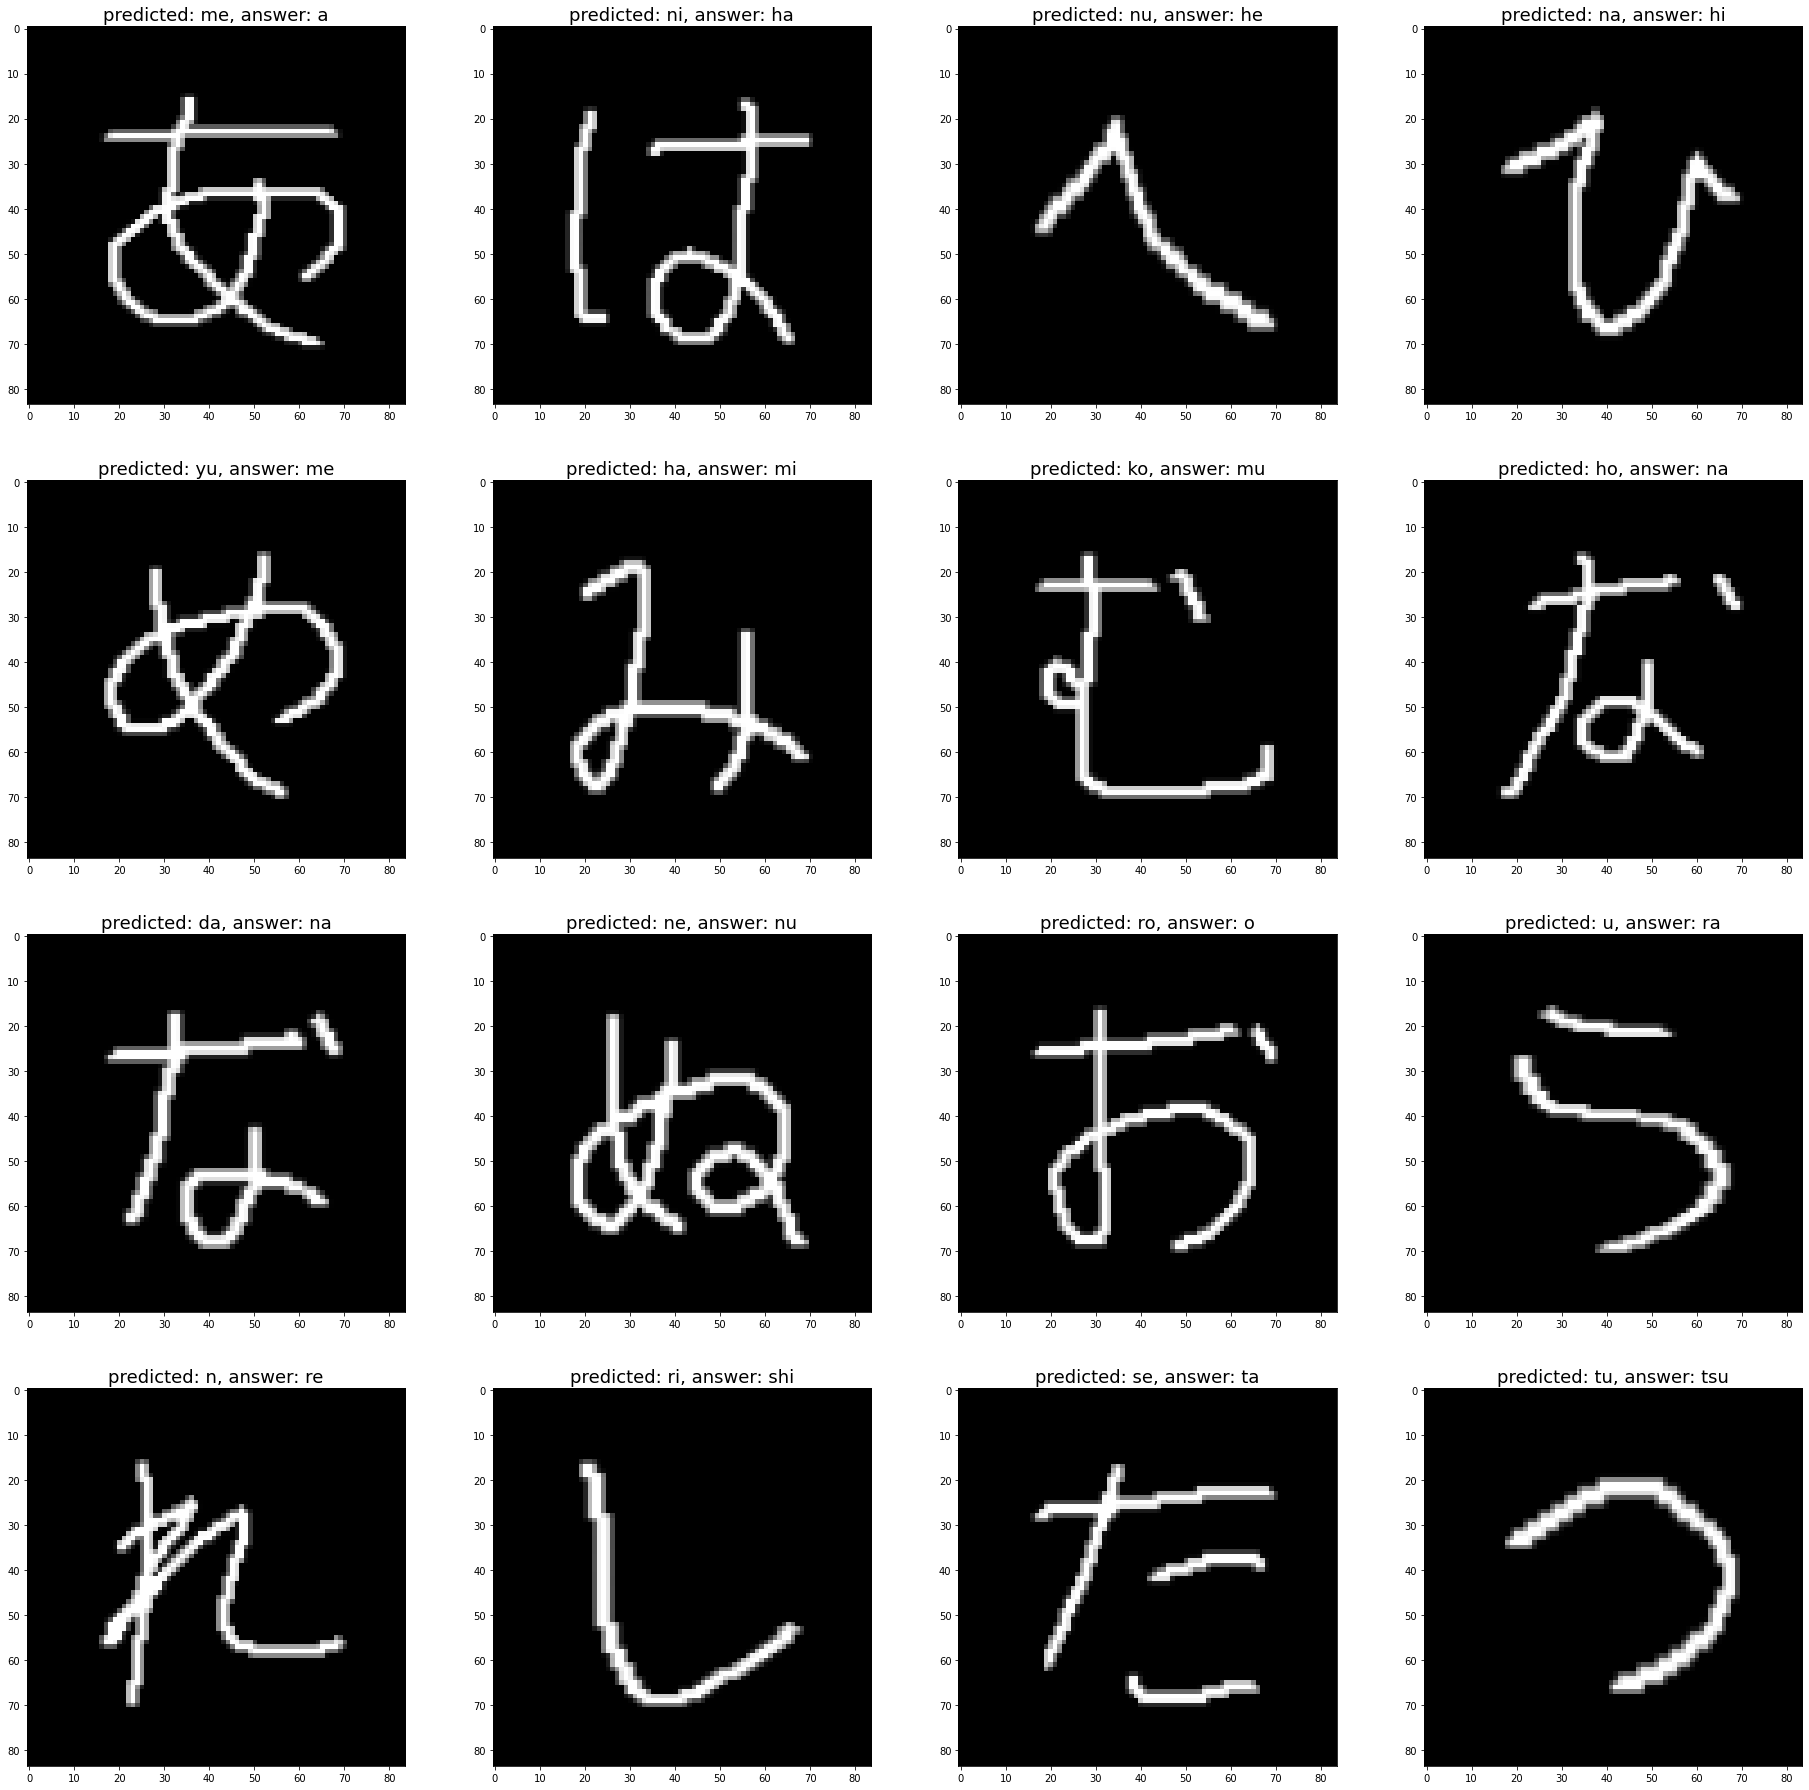

In [23]:
num_myhw = len(my_handwritings)
my_handwritings = my_handwritings.reshape(num_myhw, 84, 84, 1)
my_handwritings = std_X(my_handwritings)
print(my_handwritings.shape)
prob_myhw = model.predict(my_handwritings)
predictions_myhw = np.argmax(prob_myhw,axis=1)
# print(predictions_myhw)
prediction_romanji_myhw = [inv_romanji_dict[prediction] for prediction in predictions_myhw]
# print(prediction_romanji_myhw)
# print(answers_myhw)

errors_myhw = []
for i in range(num_myhw):
    if prediction_romanji_myhw[i] != answers_myhw[i]:
        errors_myhw.append(i)
# print(errors_myhw)
num_err_myhw = len(errors_myhw)
print("Number of errors_myhw = {}/{}".format(num_err_myhw,num_myhw))
print("Accuracy: {:.2f}".format(1-num_err_myhw/num_myhw))

num_eachrow = 4
rows_err = math.ceil(num_err_myhw / num_eachrow)
fig, axes = plt.subplots(rows_err, num_eachrow, figsize=(8*num_eachrow,8*rows_err))
for r in range(rows_err):
    for c in range(num_eachrow):
        n_err = r * num_eachrow + c
        if n_err >= num_err_myhw: break
        pos_err = errors_myhw[n_err]
        # plt.title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}")
        axes[r,c].set_title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}", fontsize=18)
        axes[r,c].imshow(my_handwritings[pos_err], cmap=plt.get_cmap('gray'))